# Patient Recovery Prediction - XGBoost Model
## Advanced Gradient Boosting Approach

**Project Deadline:** October 26th, 11:55 P.M.

**Model:** XGBoost Regressor with Hyperparameter Tuning

**Objective:** Leverage gradient boosting for improved predictions

---

## 1. Import Required Libraries

In [27]:
# Data manipulation and analysis
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# XGBoost
try:
    import xgboost as xgb
    from xgboost import XGBRegressor
    print("✅ XGBoost imported successfully!")
    print(f"   XGBoost version: {xgb.__version__}")
except ImportError:
    print("❌ XGBoost not found. Installing...")
    import sys
    !{sys.executable} -m pip install xgboost
    import xgboost as xgb
    from xgboost import XGBRegressor
    print("✅ XGBoost installed and imported!")

# Machine Learning - Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("\n✅ All libraries imported successfully!")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ XGBoost imported successfully!
   XGBoost version: 3.1.1

✅ All libraries imported successfully!
Numpy version: 1.26.4
Pandas version: 2.2.2


## 2. Load and Prepare Data

In [28]:
# Load datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("📊 Dataset loaded successfully!")
print(f"\nTraining set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nFeatures: {train_df.columns.tolist()}")
print(f"\nFirst few rows:")
display(train_df.head())

📊 Dataset loaded successfully!

Training set shape: (8000, 7)
Test set shape: (2000, 6)

Features: ['Id', 'Therapy Hours', 'Initial Health Score', 'Lifestyle Activities', 'Average Sleep Hours', 'Follow-Up Sessions', 'Recovery Index']

First few rows:


,Id,Therapy Hours,Initial Health Score,Lifestyle Activities,Average Sleep Hours,Follow-Up Sessions,Recovery Index
0,9255,5,49,No,7,5,36
1,1562,2,48,Yes,7,6,25
2,1671,2,81,No,7,2,59
3,6088,2,46,No,6,1,22
4,6670,8,47,No,9,0,40


In [29]:
# Quick data summary
print("=" * 80)
print("DATA SUMMARY")
print("=" * 80)
print(f"\nMissing values:\n{train_df.isnull().sum()}")
print(f"\nDuplicate rows: {train_df.duplicated().sum()}")
print(f"\nBasic statistics:")
display(train_df.describe())

DATA SUMMARY

Missing values:
Id                      0
Therapy Hours           0
Initial Health Score    0
Lifestyle Activities    0
Average Sleep Hours     0
Follow-Up Sessions      0
Recovery Index          0
dtype: int64

Duplicate rows: 0

Basic statistics:


,Id,Therapy Hours,Initial Health Score,Average Sleep Hours,Follow-Up Sessions,Recovery Index
count,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000
mean,5012.5069,4.9832,69.5310,6.5416,4.6165,55.3115
std,2887.6494,2.5949,17.3437,1.6985,2.8612,19.2021
min,2.0000,1.0000,40.0000,4.0000,0.0000,10.0000
25%,2512.7500,3.0000,54.7500,5.0000,2.0000,40.0000
50%,5014.5000,5.0000,70.0000,7.0000,5.0000,55.0000
75%,7505.2500,7.0000,85.0000,8.0000,7.0000,71.0000
max,10000.0000,9.0000,99.0000,9.0000,9.0000,100.0000


## 3. Data Preprocessing

In [30]:
def calculate_accuracy(y_true, y_pred, tolerance=2.0):
    """
    Calculate accuracy for regression tasks using a tolerance threshold.
    Predictions within ±tolerance of actual values are counted as correct.
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    tolerance : float, default=2.0
        Tolerance threshold for considering predictions as "correct"
    
    Returns:
    --------
    accuracy : float
        Correct predictions / total predictions
    """
    correct_predictions = np.abs(y_true - y_pred) <= tolerance
    accuracy = correct_predictions.sum() / len(y_true)
    return accuracy

# Test the function
print("=" * 80)
print("CUSTOM ACCURACY METRIC FOR REGRESSION")
print("=" * 80)
print(f"\n✅ Function defined: calculate_accuracy(y_true, y_pred, tolerance=2.0)")
print(f"\nHow it works:")
print(f"  - Predictions within ±{2.0} of actual values = 'correct'")
print(f"  - Accuracy = correct predictions / total predictions")
print(f"  - Useful for understanding practical prediction accuracy")
print(f"\nYou can adjust tolerance based on problem requirements:")
print(f"  - tolerance=1.0  → stricter (predictions within ±1)")
print(f"  - tolerance=2.0  → moderate (default)")
print(f"  - tolerance=5.0  → lenient (predictions within ±5)")

CUSTOM ACCURACY METRIC FOR REGRESSION

✅ Function defined: calculate_accuracy(y_true, y_pred, tolerance=2.0)

How it works:
  - Predictions within ±2.0 of actual values = 'correct'
  - Accuracy = correct predictions / total predictions
  - Useful for understanding practical prediction accuracy

You can adjust tolerance based on problem requirements:
  - tolerance=1.0  → stricter (predictions within ±1)
  - tolerance=2.0  → moderate (default)
  - tolerance=5.0  → lenient (predictions within ±5)


## 3A. Custom Accuracy Metric for Regression

Define a tolerance-based accuracy metric: predictions within a threshold are counted as "correct"

In [31]:
# Prepare features and target
X = train_df.drop(['Id', 'Recovery Index'], axis=1).copy()
y = train_df['Recovery Index'].copy()

# Encode categorical variable
label_encoder = LabelEncoder()
X['Lifestyle Activities'] = label_encoder.fit_transform(X['Lifestyle Activities'])

print("=" * 80)
print("FEATURE PREPARATION")
print("=" * 80)
print(f"✅ Lifestyle Activities encoded (No=0, Yes=1)")
print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns: {X.columns.tolist()}")
print(f"\nTarget statistics:")
print(f"  Mean: {y.mean():.2f}")
print(f"  Std: {y.std():.2f}")
print(f"  Range: [{y.min()}, {y.max()}]")

FEATURE PREPARATION
✅ Lifestyle Activities encoded (No=0, Yes=1)

Feature matrix shape: (8000, 5)
Target vector shape: (8000,)

Feature columns: ['Therapy Hours', 'Initial Health Score', 'Lifestyle Activities', 'Average Sleep Hours', 'Follow-Up Sessions']

Target statistics:
  Mean: 55.31
  Std: 19.20
  Range: [10, 100]


In [32]:
def create_advanced_features(df):
    """
    Create advanced features from existing ones.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with features
    
    Returns:
    --------
    df_enhanced : pandas.DataFrame
        DataFrame with additional engineered features
    """
    df_enhanced = df.copy()
    
    # Interaction Features
    df_enhanced['therapy_health_interaction'] = df_enhanced['Therapy Hours'] * df_enhanced['Initial Health Score']
    df_enhanced['therapy_followup_interaction'] = df_enhanced['Therapy Hours'] * df_enhanced['Follow-Up Sessions']
    df_enhanced['sleep_health_interaction'] = df_enhanced['Average Sleep Hours'] * df_enhanced['Initial Health Score']
    df_enhanced['therapy_sleep_interaction'] = df_enhanced['Therapy Hours'] * df_enhanced['Average Sleep Hours']
    
    # Ratio Features
    df_enhanced['therapy_per_followup'] = df_enhanced['Therapy Hours'] / (df_enhanced['Follow-Up Sessions'] + 1)  # +1 to avoid division by zero
    df_enhanced['health_per_sleep'] = df_enhanced['Initial Health Score'] / (df_enhanced['Average Sleep Hours'] + 1)
    df_enhanced['therapy_per_sleep'] = df_enhanced['Therapy Hours'] / (df_enhanced['Average Sleep Hours'] + 1)
    df_enhanced['followup_per_therapy'] = df_enhanced['Follow-Up Sessions'] / (df_enhanced['Therapy Hours'] + 1)
    
    # Polynomial Features (degree 2 for most important features)
    df_enhanced['therapy_hours_squared'] = df_enhanced['Therapy Hours'] ** 2
    df_enhanced['health_score_squared'] = df_enhanced['Initial Health Score'] ** 2
    df_enhanced['sleep_hours_squared'] = df_enhanced['Average Sleep Hours'] ** 2
    df_enhanced['followup_squared'] = df_enhanced['Follow-Up Sessions'] ** 2
    
    # Binning Features (create categorical versions)
    df_enhanced['sleep_category'] = pd.cut(df_enhanced['Average Sleep Hours'], 
                                            bins=[0, 5, 7, 9, 12], 
                                            labels=[0, 1, 2, 3], right=False)
    df_enhanced['health_category'] = pd.cut(df_enhanced['Initial Health Score'], 
                                             bins=[0, 25, 50, 75, 100], 
                                             labels=[0, 1, 2, 3], right=False)
    df_enhanced['therapy_level'] = pd.cut(df_enhanced['Therapy Hours'], 
                                           bins=[0, 3, 6, 9, 100], 
                                           labels=[0, 1, 2, 3], right=False)
    
    # Convert categorical bins to numeric
    df_enhanced['sleep_category'] = df_enhanced['sleep_category'].astype(float)
    df_enhanced['health_category'] = df_enhanced['health_category'].astype(float)
    df_enhanced['therapy_level'] = df_enhanced['therapy_level'].astype(float)
    
    # Combined score features
    df_enhanced['overall_care_score'] = (df_enhanced['Therapy Hours'] + 
                                          df_enhanced['Follow-Up Sessions'] + 
                                          df_enhanced['Initial Health Score'] +
                                          df_enhanced['Average Sleep Hours']) / 4
    
    df_enhanced['weighted_care_score'] = (df_enhanced['Therapy Hours'] * 0.3 + 
                                           df_enhanced['Follow-Up Sessions'] * 0.2 + 
                                           df_enhanced['Initial Health Score'] * 0.3 +
                                           df_enhanced['Average Sleep Hours'] * 0.2)
    
    return df_enhanced

# Apply feature engineering to training data
print("=" * 80)
print("ADVANCED FEATURE ENGINEERING")
print("=" * 80)
print(f"\nOriginal features: {X.shape[1]}")
X_engineered = create_advanced_features(X)
print(f"Enhanced features: {X_engineered.shape[1]}")
print(f"New features added: {X_engineered.shape[1] - X.shape[1]}")

print(f"\n📋 New feature list:")
new_features = [col for col in X_engineered.columns if col not in X.columns]
for i, feat in enumerate(new_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n✅ Feature engineering completed!")
print(f"\nEnhanced feature set preview:")
display(X_engineered.head())

ADVANCED FEATURE ENGINEERING

Original features: 5
Enhanced features: 22
New features added: 17

📋 New feature list:
   1. therapy_health_interaction
   2. therapy_followup_interaction
   3. sleep_health_interaction
   4. therapy_sleep_interaction
   5. therapy_per_followup
   6. health_per_sleep
   7. therapy_per_sleep
   8. followup_per_therapy
   9. therapy_hours_squared
  10. health_score_squared
  11. sleep_hours_squared
  12. followup_squared
  13. sleep_category
  14. health_category
  15. therapy_level
  16. overall_care_score
  17. weighted_care_score

✅ Feature engineering completed!

Enhanced feature set preview:


,Therapy Hours,Initial Health Score,Lifestyle Activities,Average Sleep Hours,Follow-Up Sessions,therapy_health_interaction,therapy_followup_interaction,sleep_health_interaction,therapy_sleep_interaction,therapy_per_followup,health_per_sleep,therapy_per_sleep,followup_per_therapy,therapy_hours_squared,health_score_squared,sleep_hours_squared,followup_squared,sleep_category,health_category,therapy_level,overall_care_score,weighted_care_score
0,5,49,0,7,5,245,25,343,35,0.8333,6.1250,0.6250,0.8333,25,2401,49,25,2.0,1.0,1.0,16.50,18.6
1,2,48,1,7,6,96,12,336,14,0.2857,6.0000,0.2500,2.0000,4,2304,49,36,2.0,1.0,0.0,15.75,17.6
2,2,81,0,7,2,162,4,567,14,0.6667,10.1250,0.2500,0.6667,4,6561,49,4,2.0,3.0,0.0,23.00,26.7
3,2,46,0,6,1,92,2,276,12,1.0000,6.5714,0.2857,0.3333,4,2116,36,1,1.0,1.0,0.0,13.75,15.8
4,8,47,0,9,0,376,0,423,72,8.0000,4.7000,0.8000,0.0000,64,2209,81,0,3.0,1.0,2.0,16.00,18.3


## 3B. Advanced Feature Engineering

Create new features to capture complex relationships and improve model performance

In [33]:
# Train-validation split (using engineered features)
X_train, X_val, y_train, y_val = train_test_split(X_engineered, y, test_size=0.2, random_state=42)

print("=" * 80)
print("TRAIN-VALIDATION SPLIT (With Engineered Features)")
print("=" * 80)
print(f"Training set: {X_train.shape[0]} samples ({(X_train.shape[0]/X_engineered.shape[0])*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({(X_val.shape[0]/X_engineered.shape[0])*100:.1f}%)")
print(f"Number of features: {X_train.shape[1]}")
print(f"\nTraining target statistics:")
print(f"  Mean: {y_train.mean():.2f}")
print(f"  Std: {y_train.std():.2f}")

TRAIN-VALIDATION SPLIT (With Engineered Features)
Training set: 6400 samples (80.0%)
Validation set: 1600 samples (20.0%)
Number of features: 22

Training target statistics:
  Mean: 55.33
  Std: 19.19


In [34]:
# Create scaled versions for comparison and ensemble methods
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame to preserve column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

print("=" * 80)
print("FEATURE SCALING")
print("=" * 80)
print("✅ Features scaled using StandardScaler (mean=0, std=1)")
print(f"\nScaled training set shape: {X_train_scaled.shape}")
print(f"Scaled validation set shape: {X_val_scaled.shape}")
print(f"\nNote: XGBoost doesn't require scaling (tree-based), but scaled")
print(f"      features will be used for ensemble methods like stacking.")

FEATURE SCALING
✅ Features scaled using StandardScaler (mean=0, std=1)

Scaled training set shape: (6400, 22)
Scaled validation set shape: (1600, 22)

Note: XGBoost doesn't require scaling (tree-based), but scaled
      features will be used for ensemble methods like stacking.


## 3C. Feature Scaling (Optional for XGBoost)

XGBoost is tree-based and doesn't require scaling, but we'll prepare scaled versions for ensemble methods

## 4. Baseline XGBoost Model (Default Parameters)

In [35]:
# Train baseline XGBoost with default parameters
print("=" * 80)
print("BASELINE XGBOOST MODEL (Default Parameters)")
print("=" * 80)

xgb_baseline = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_baseline.fit(X_train, y_train)

# Make predictions
y_train_pred_baseline = xgb_baseline.predict(X_train)
y_val_pred_baseline = xgb_baseline.predict(X_val)

# Calculate metrics
train_r2_baseline = r2_score(y_train, y_train_pred_baseline)
val_r2_baseline = r2_score(y_val, y_val_pred_baseline)
train_rmse_baseline = np.sqrt(mean_squared_error(y_train, y_train_pred_baseline))
val_rmse_baseline = np.sqrt(mean_squared_error(y_val, y_val_pred_baseline))
train_mae_baseline = mean_absolute_error(y_train, y_train_pred_baseline)
val_mae_baseline = mean_absolute_error(y_val, y_val_pred_baseline)

# Calculate ACCURACY (tolerance-based)
train_acc_baseline = calculate_accuracy(y_train, y_train_pred_baseline, tolerance=2.0)
val_acc_baseline = calculate_accuracy(y_val, y_val_pred_baseline, tolerance=2.0)

print(f"\n{'Metric':<25} {'Training':>15} {'Validation':>15}")
print("-" * 80)
print(f"{'R² Score':<25} {train_r2_baseline:>15.4f} {val_r2_baseline:>15.4f}")
print(f"{'RMSE':<25} {train_rmse_baseline:>15.4f} {val_rmse_baseline:>15.4f}")
print(f"{'MAE':<25} {train_mae_baseline:>15.4f} {val_mae_baseline:>15.4f}")
print(f"{'Accuracy (±2.0)':<25} {train_acc_baseline:>15.4f} {val_acc_baseline:>15.4f}")
print(f"{'Accuracy %':<25} {train_acc_baseline*100:>14.2f}% {val_acc_baseline*100:>14.2f}%")
print("=" * 80)

# Check for overfitting
overfitting_diff = abs(train_r2_baseline - val_r2_baseline)
if overfitting_diff < 0.05:
    print(f"\n✅ Model is well-balanced (R² difference: {overfitting_diff:.4f})")
else:
    print(f"\n⚠️ Potential overfitting detected (R² difference: {overfitting_diff:.4f})")

BASELINE XGBOOST MODEL (Default Parameters)

Metric                           Training      Validation
--------------------------------------------------------------------------------
R² Score                           0.9956          0.9858
RMSE                               1.2758          2.2916
MAE                                0.9850          1.8016
Accuracy (±2.0)                    0.8839          0.6269
Accuracy %                         88.39%          62.69%

✅ Model is well-balanced (R² difference: 0.0098)


## 5. Feature Importance Analysis (Baseline)

FEATURE IMPORTANCE (Baseline XGBoost)
                         Feature  Importance
21           weighted_care_score      0.8869
5     therapy_health_interaction      0.0910
9           therapy_per_followup      0.0063
1           Initial Health Score      0.0041
12          followup_per_therapy      0.0022
8      therapy_sleep_interaction      0.0014
11             therapy_per_sleep      0.0012
20            overall_care_score      0.0011
2           Lifestyle Activities      0.0011
10              health_per_sleep      0.0010
7       sleep_health_interaction      0.0010
6   therapy_followup_interaction      0.0009
4             Follow-Up Sessions      0.0008
3            Average Sleep Hours      0.0005
0                  Therapy Hours      0.0003
13         therapy_hours_squared      0.0000
14          health_score_squared      0.0000
15           sleep_hours_squared      0.0000
16              followup_squared      0.0000
17                sleep_category      0.0000
18               

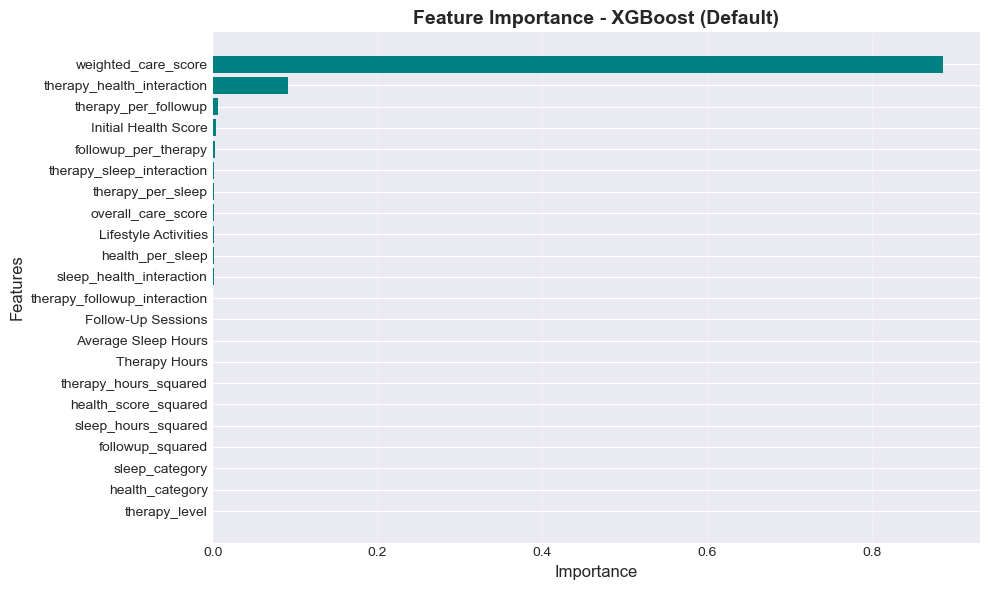

In [36]:
# Get feature importance
feature_importance_baseline = pd.DataFrame({
    'Feature': X_engineered.columns,
    'Importance': xgb_baseline.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE (Baseline XGBoost)")
print("=" * 80)
print(feature_importance_baseline)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_baseline['Feature'], feature_importance_baseline['Importance'], color='teal')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - XGBoost (Default)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 6. Hyperparameter Tuning with RandomizedSearchCV

Using RandomizedSearchCV for efficiency with large parameter spaces

In [37]:
# Define parameter distribution for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.1, 1, 5, 10]
}

print("=" * 80)
print("HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH")
print("=" * 80)
print(f"\nParameter distributions:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

print(f"\nRandomized search will test 100 random combinations")
print(f"This is more efficient than testing all combinations!")
print("\n🔄 Starting Randomized Search (this may take several minutes)...")

HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH

Parameter distributions:
  n_estimators: [100, 200, 300, 500]
  max_depth: [3, 5, 7, 9, 11]
  learning_rate: [0.01, 0.05, 0.1, 0.2]
  subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  colsample_bytree: [0.6, 0.7, 0.8, 0.9, 1.0]
  min_child_weight: [1, 3, 5, 7]
  gamma: [0, 0.1, 0.2, 0.3, 0.5]
  reg_alpha: [0, 0.01, 0.1, 1]
  reg_lambda: [0.1, 1, 5, 10]

Randomized search will test 100 random combinations
This is more efficient than testing all combinations!

🔄 Starting Randomized Search (this may take several minutes)...


In [38]:
# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_distributions,
    n_iter=100,  # Number of random combinations to try
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\n" + "=" * 80)
print("RANDOMIZED SEARCH RESULTS")
print("=" * 80)
print(f"\n✅ Randomized Search completed!")
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation R² score: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits

RANDOMIZED SEARCH RESULTS

✅ Randomized Search completed!

Best parameters:
  subsample: 0.6
  reg_lambda: 0.1
  reg_alpha: 0.1
  n_estimators: 200
  min_child_weight: 5
  max_depth: 3
  learning_rate: 0.05
  gamma: 0
  colsample_bytree: 0.8

Best cross-validation R² score: 0.9876


In [39]:
# Get top 10 parameter combinations
cv_results = pd.DataFrame(random_search.cv_results_)
top_10 = cv_results.nlargest(10, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

print("\n" + "=" * 80)
print("TOP 10 PARAMETER COMBINATIONS")
print("=" * 80)
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Mean R² Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")


TOP 10 PARAMETER COMBINATIONS

Rank 1:
  Mean R² Score: 0.9876 (+/- 0.0007)
  Parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

Rank 2:
  Mean R² Score: 0.9875 (+/- 0.0006)
  Parameters: {'subsample': 0.9, 'reg_lambda': 5, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}

Rank 3:
  Mean R² Score: 0.9875 (+/- 0.0006)
  Parameters: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.9}

Rank 4:
  Mean R² Score: 0.9875 (+/- 0.0006)
  Parameters: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}

Rank 5:
  Mean R² Score: 0.987

## 7. Evaluate Tuned XGBoost Model

In [40]:
# Get the best model
xgb_tuned = random_search.best_estimator_

# Make predictions
y_train_pred_tuned = xgb_tuned.predict(X_train)
y_val_pred_tuned = xgb_tuned.predict(X_val)

# Calculate metrics
train_r2_tuned = r2_score(y_train, y_train_pred_tuned)
val_r2_tuned = r2_score(y_val, y_val_pred_tuned)
train_rmse_tuned = np.sqrt(mean_squared_error(y_train, y_train_pred_tuned))
val_rmse_tuned = np.sqrt(mean_squared_error(y_val, y_val_pred_tuned))
train_mae_tuned = mean_absolute_error(y_train, y_train_pred_tuned)
val_mae_tuned = mean_absolute_error(y_val, y_val_pred_tuned)

# Calculate ACCURACY (tolerance-based)
train_acc_tuned = calculate_accuracy(y_train, y_train_pred_tuned, tolerance=2.0)
val_acc_tuned = calculate_accuracy(y_val, y_val_pred_tuned, tolerance=2.0)

print("=" * 80)
print("TUNED XGBOOST MODEL PERFORMANCE")
print("=" * 80)
print(f"\n{'Metric':<25} {'Training':>15} {'Validation':>15}")
print("-" * 80)
print(f"{'R² Score':<25} {train_r2_tuned:>15.4f} {val_r2_tuned:>15.4f}")
print(f"{'RMSE':<25} {train_rmse_tuned:>15.4f} {val_rmse_tuned:>15.4f}")
print(f"{'MAE':<25} {train_mae_tuned:>15.4f} {val_mae_tuned:>15.4f}")
print(f"{'Accuracy (±2.0)':<25} {train_acc_tuned:>15.4f} {val_acc_tuned:>15.4f}")
print(f"{'Accuracy %':<25} {train_acc_tuned*100:>14.2f}% {val_acc_tuned*100:>14.2f}%")
print("=" * 80)

# Check for overfitting
overfitting_diff_tuned = abs(train_r2_tuned - val_r2_tuned)
if overfitting_diff_tuned < 0.05:
    print(f"\n✅ Model is well-balanced (R² difference: {overfitting_diff_tuned:.4f})")
else:
    print(f"\n⚠️ Potential overfitting detected (R² difference: {overfitting_diff_tuned:.4f})")

TUNED XGBOOST MODEL PERFORMANCE

Metric                           Training      Validation
--------------------------------------------------------------------------------
R² Score                           0.9891          0.9882
RMSE                               1.9997          2.0887
MAE                                1.5877          1.6645
Accuracy (±2.0)                    0.6889          0.6644
Accuracy %                         68.89%          66.44%

✅ Model is well-balanced (R² difference: 0.0009)


## 8. Model Comparison: Baseline vs Tuned

In [41]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': ['XGB Baseline', 'XGB Tuned'],
    'Train R²': [train_r2_baseline, train_r2_tuned],
    'Val R²': [val_r2_baseline, val_r2_tuned],
    'Train RMSE': [train_rmse_baseline, train_rmse_tuned],
    'Val RMSE': [val_rmse_baseline, val_rmse_tuned],
    'Train MAE': [train_mae_baseline, train_mae_tuned],
    'Val MAE': [val_mae_baseline, val_mae_tuned]
})

print("=" * 80)
print("MODEL COMPARISON: BASELINE vs TUNED")
print("=" * 80)
display(comparison_df)

# Calculate improvement
r2_improvement = ((val_r2_tuned - val_r2_baseline) / val_r2_baseline) * 100
rmse_improvement = ((val_rmse_baseline - val_rmse_tuned) / val_rmse_baseline) * 100

print(f"\n📈 Improvement with tuning:")
print(f"  Validation R² improvement: {r2_improvement:+.2f}%")
print(f"  Validation RMSE improvement: {rmse_improvement:+.2f}%")

MODEL COMPARISON: BASELINE vs TUNED


,Model,Train R²,Val R²,Train RMSE,Val RMSE,Train MAE,Val MAE
0,XGB Baseline,0.9956,0.9858,1.2758,2.2916,0.9850,1.8016
1,XGB Tuned,0.9891,0.9882,1.9997,2.0887,1.5877,1.6645



📈 Improvement with tuning:
  Validation R² improvement: +0.24%
  Validation RMSE improvement: +8.85%


In [42]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge

print("=" * 80)
print("ENSEMBLE STACKING")
print("=" * 80)

# Define base models (Level 0)
base_models = [
    ('xgboost', xgb_tuned),
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42))
]

# Define meta-model (Level 1)
meta_model = Ridge(alpha=1.0)

# Create stacking ensemble
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

print("🔄 Training stacking ensemble (this may take a few minutes)...")
print(f"\nBase models (Level 0):")
for name, model in base_models:
    print(f"  - {name}: {type(model).__name__}")
print(f"\nMeta-model (Level 1): {type(meta_model).__name__}")
print(f"Cross-validation folds: 5")

# Train the ensemble
stacking_model.fit(X_train, y_train)

print("\n✅ Stacking ensemble trained successfully!")

ENSEMBLE STACKING
🔄 Training stacking ensemble (this may take a few minutes)...

Base models (Level 0):
  - xgboost: XGBRegressor
  - rf: RandomForestRegressor
  - gb: GradientBoostingRegressor

Meta-model (Level 1): Ridge
Cross-validation folds: 5

✅ Stacking ensemble trained successfully!


In [43]:
# Evaluate stacking ensemble
y_train_pred_stack = stacking_model.predict(X_train)
y_val_pred_stack = stacking_model.predict(X_val)

# Calculate metrics
train_r2_stack = r2_score(y_train, y_train_pred_stack)
val_r2_stack = r2_score(y_val, y_val_pred_stack)
train_rmse_stack = np.sqrt(mean_squared_error(y_train, y_train_pred_stack))
val_rmse_stack = np.sqrt(mean_squared_error(y_val, y_val_pred_stack))
train_mae_stack = mean_absolute_error(y_train, y_train_pred_stack)
val_mae_stack = mean_absolute_error(y_val, y_val_pred_stack)
train_acc_stack = calculate_accuracy(y_train, y_train_pred_stack, tolerance=2.0)
val_acc_stack = calculate_accuracy(y_val, y_val_pred_stack, tolerance=2.0)

print("=" * 80)
print("STACKING ENSEMBLE PERFORMANCE")
print("=" * 80)
print(f"\n{'Metric':<25} {'Training':>15} {'Validation':>15}")
print("-" * 80)
print(f"{'R² Score':<25} {train_r2_stack:>15.4f} {val_r2_stack:>15.4f}")
print(f"{'RMSE':<25} {train_rmse_stack:>15.4f} {val_rmse_stack:>15.4f}")
print(f"{'MAE':<25} {train_mae_stack:>15.4f} {val_mae_stack:>15.4f}")
print(f"{'Accuracy (±2.0)':<25} {train_acc_stack:>15.4f} {val_acc_stack:>15.4f}")
print(f"{'Accuracy %':<25} {train_acc_stack*100:>14.2f}% {val_acc_stack*100:>14.2f}%")
print("=" * 80)

# Compare with tuned XGBoost
improvement_r2 = ((val_r2_stack - val_r2_tuned) / val_r2_tuned) * 100
improvement_rmse = ((val_rmse_tuned - val_rmse_stack) / val_rmse_tuned) * 100

print(f"\n📈 Improvement over Tuned XGBoost:")
print(f"  Validation R² improvement: {improvement_r2:+.2f}%")
print(f"  Validation RMSE improvement: {improvement_rmse:+.2f}%")

if val_r2_stack > val_r2_tuned:
    print(f"\n✅ Stacking ensemble outperforms single XGBoost model!")
else:
    print(f"\n⚠️ Single XGBoost model performs better (simpler is better in this case)")

STACKING ENSEMBLE PERFORMANCE

Metric                           Training      Validation
--------------------------------------------------------------------------------
R² Score                           0.9906          0.9883
RMSE                               1.8585          2.0801
MAE                                1.4745          1.6563
Accuracy (±2.0)                    0.7211          0.6669
Accuracy %                         72.11%          66.69%

📈 Improvement over Tuned XGBoost:
  Validation R² improvement: +0.01%
  Validation RMSE improvement: +0.41%

✅ Stacking ensemble outperforms single XGBoost model!


## 8A. Ensemble Stacking for Enhanced Predictions

Combine XGBoost with other models using stacking for potentially better performance

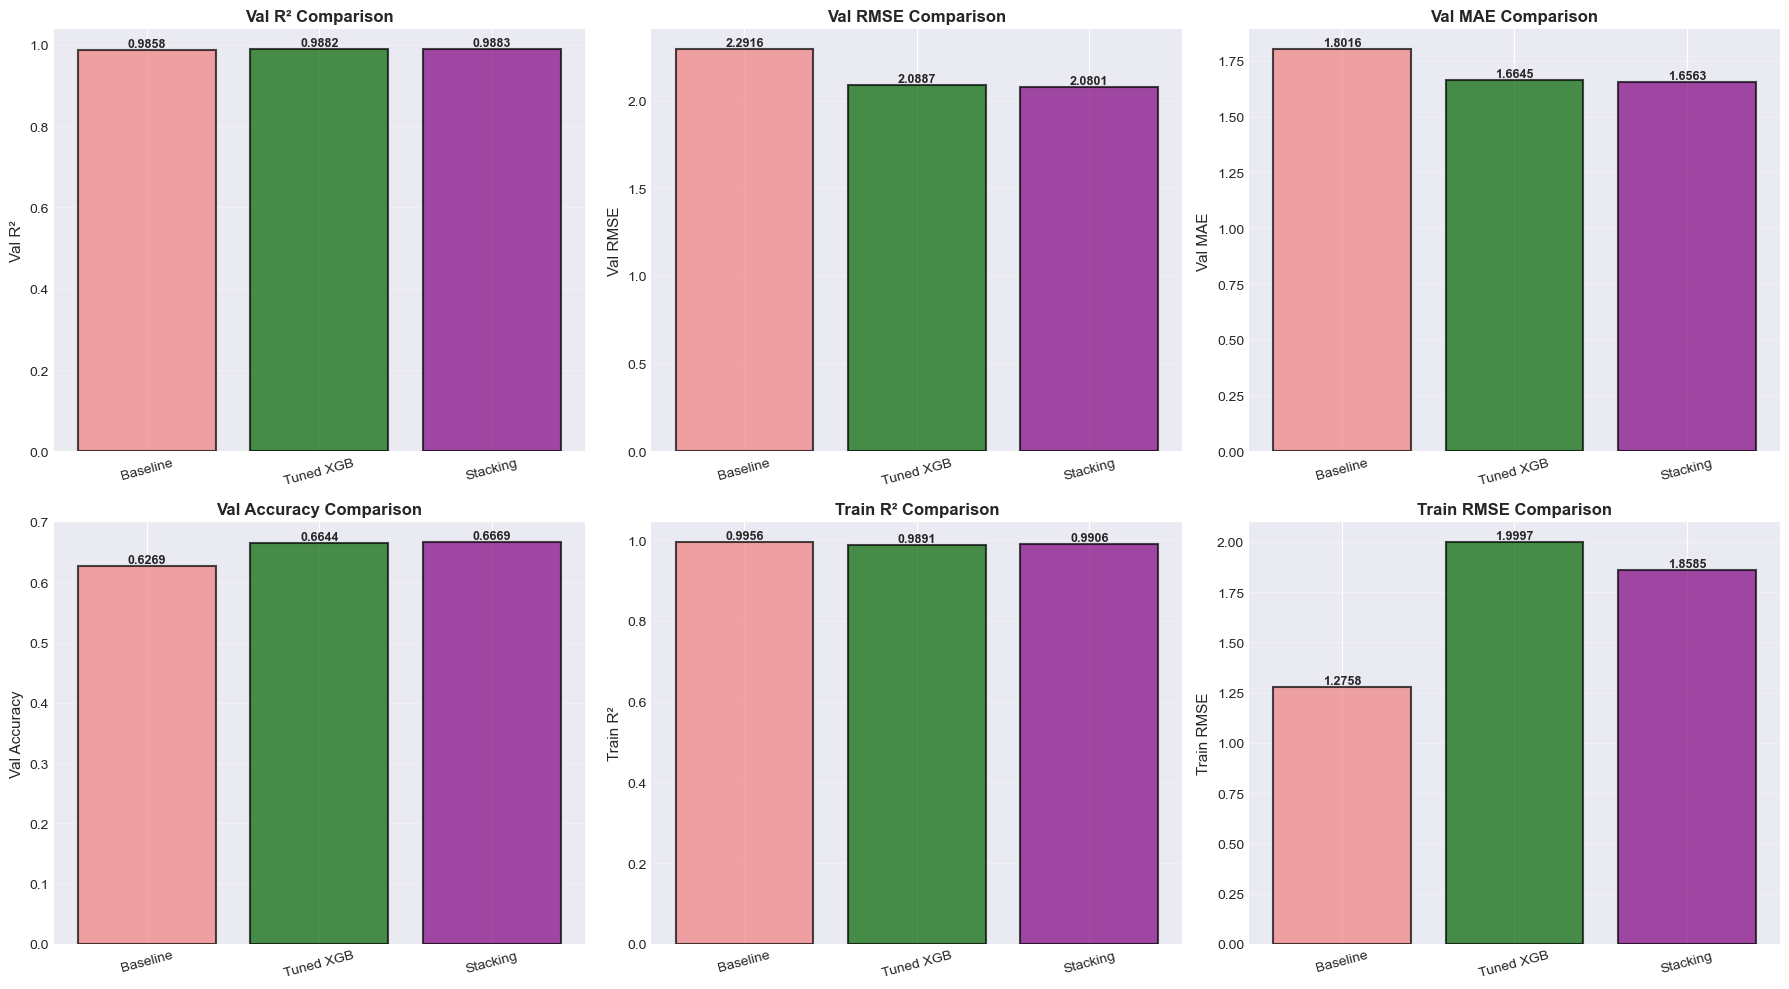

In [44]:
# Visualize model comparison (now with 3 models)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Val R²', 'Val RMSE', 'Val MAE', 'Val Accuracy', 'Train R²', 'Train RMSE']
baseline_vals = [val_r2_baseline, val_rmse_baseline, val_mae_baseline, 
                 val_acc_baseline, train_r2_baseline, train_rmse_baseline]
tuned_vals = [val_r2_tuned, val_rmse_tuned, val_mae_tuned, 
              val_acc_tuned, train_r2_tuned, train_rmse_tuned]
stack_vals = [val_r2_stack, val_rmse_stack, val_mae_stack, 
              val_acc_stack, train_r2_stack, train_rmse_stack]

for idx, (metric, baseline_val, tuned_val, stack_val) in enumerate(zip(metrics, baseline_vals, tuned_vals, stack_vals)):
    row = idx // 3
    col = idx % 3
    
    x = ['Baseline', 'Tuned XGB', 'Stacking']
    y = [baseline_val, tuned_val, stack_val]
    colors = ['lightcoral', 'darkgreen', 'purple']
    
    bars = axes[row, col].bar(x, y, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[row, col].set_ylabel(metric, fontsize=11)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].grid(alpha=0.3, axis='y')
    axes[row, col].tick_params(axis='x', rotation=15)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.4f}',
                           ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

## 9. Learning Curves

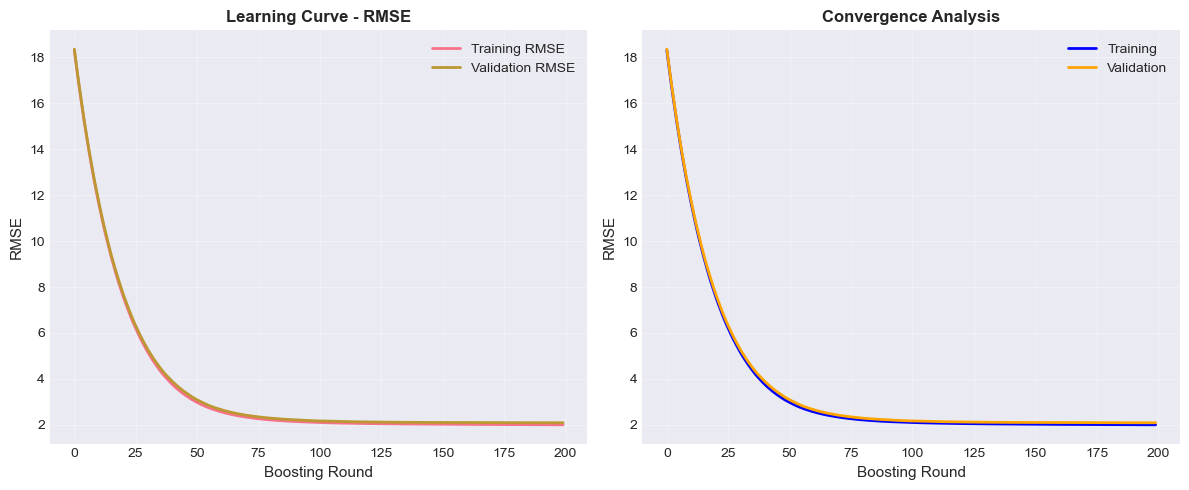


Best iteration: 199
Best validation RMSE: 2.0887


In [45]:
# Plot learning curves for tuned model
eval_set = [(X_train, y_train), (X_val, y_val)]

# Train a new model with early stopping to get learning curves
xgb_learning = XGBRegressor(**xgb_tuned.get_params())
xgb_learning.set_params(early_stopping_rounds=20, eval_metric='rmse')

xgb_learning.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=False
)

# Get results
results = xgb_learning.evals_result()

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results['validation_0']['rmse'], label='Training RMSE', linewidth=2)
plt.plot(results['validation_1']['rmse'], label='Validation RMSE', linewidth=2)
plt.xlabel('Boosting Round', fontsize=11)
plt.ylabel('RMSE', fontsize=11)
plt.title('Learning Curve - RMSE', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
plt.plot(x_axis, results['validation_0']['rmse'], label='Training', linewidth=2, color='blue')
plt.plot(x_axis, results['validation_1']['rmse'], label='Validation', linewidth=2, color='orange')
plt.xlabel('Boosting Round', fontsize=11)
plt.ylabel('RMSE', fontsize=11)
plt.title('Convergence Analysis', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest iteration: {xgb_learning.best_iteration}")
print(f"Best validation RMSE: {results['validation_1']['rmse'][xgb_learning.best_iteration]:.4f}")

## 10. Visualization: Actual vs Predicted

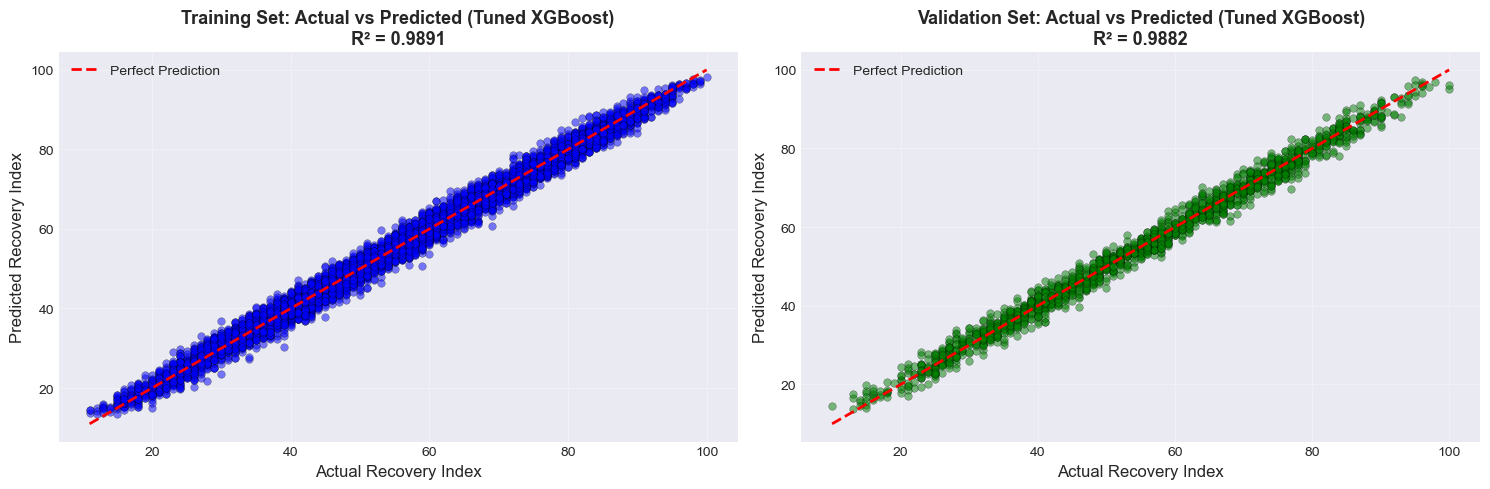

In [46]:
# Plot Actual vs Predicted for Tuned Model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set
axes[0].scatter(y_train, y_train_pred_tuned, alpha=0.5, s=30, color='blue', edgecolors='black', linewidth=0.3)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Recovery Index', fontsize=12)
axes[0].set_ylabel('Predicted Recovery Index', fontsize=12)
axes[0].set_title(f'Training Set: Actual vs Predicted (Tuned XGBoost)\nR² = {train_r2_tuned:.4f}', 
                 fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Validation set
axes[1].scatter(y_val, y_val_pred_tuned, alpha=0.5, s=30, color='green', edgecolors='black', linewidth=0.3)
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
            'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Recovery Index', fontsize=12)
axes[1].set_ylabel('Predicted Recovery Index', fontsize=12)
axes[1].set_title(f'Validation Set: Actual vs Predicted (Tuned XGBoost)\nR² = {val_r2_tuned:.4f}', 
                 fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Residual Analysis

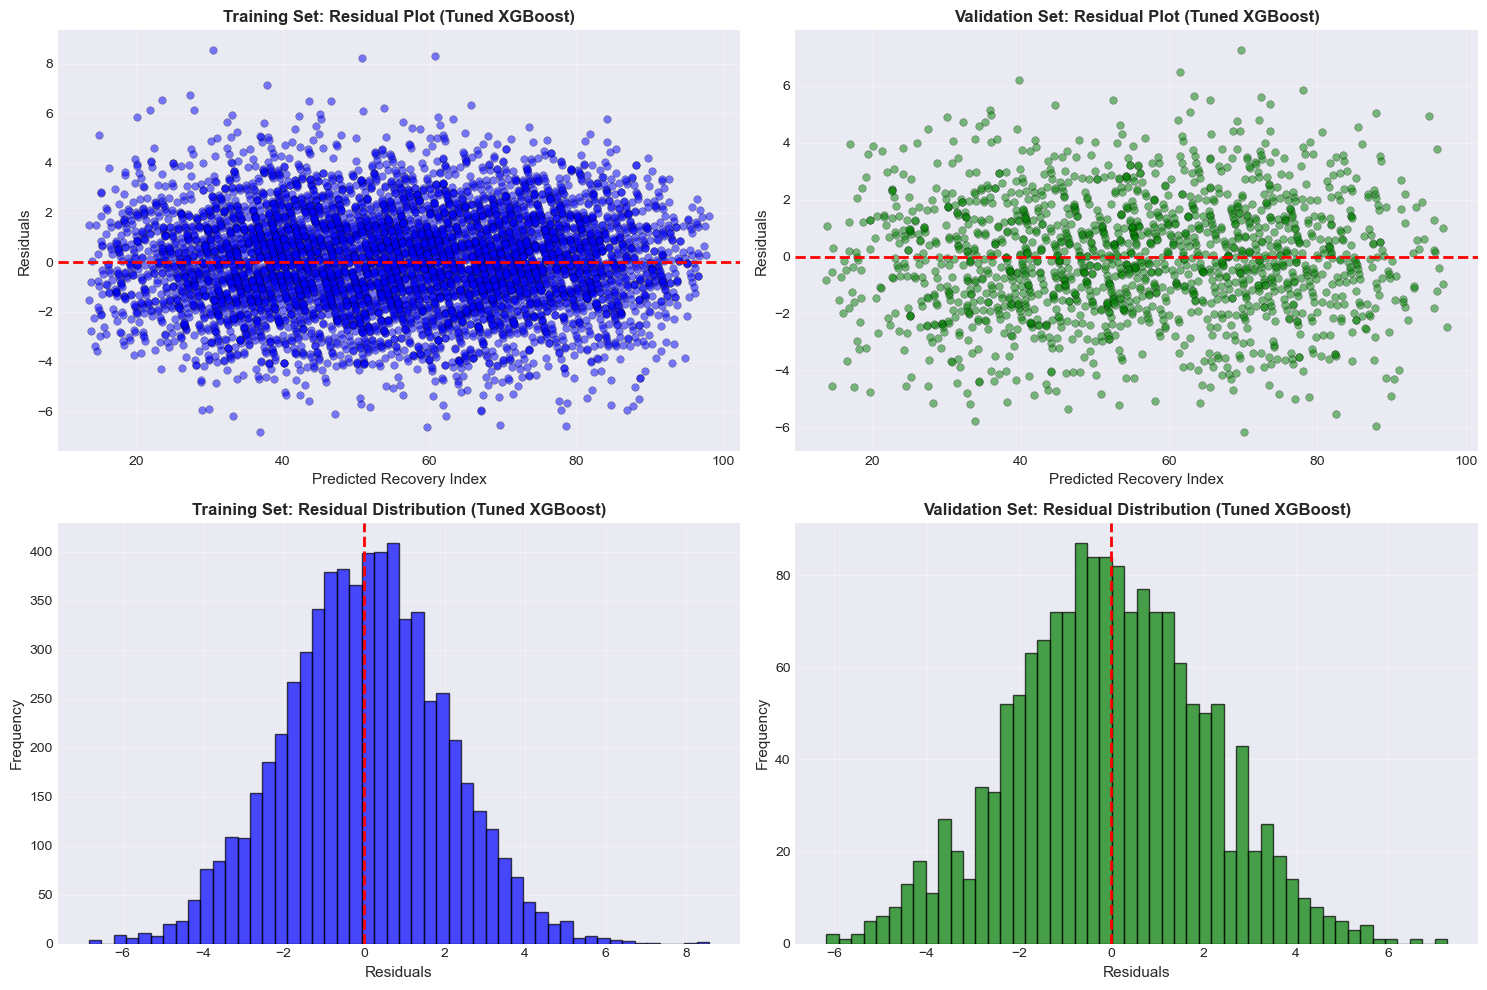

RESIDUAL STATISTICS

Training Set:
  Mean residual: 0.0041
  Std residual: 1.9999

Validation Set:
  Mean residual: -0.0413
  Std residual: 2.0890


In [47]:
# Calculate residuals
residuals_train_tuned = y_train - y_train_pred_tuned
residuals_val_tuned = y_val - y_val_pred_tuned

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training residuals vs predicted
axes[0, 0].scatter(y_train_pred_tuned, residuals_train_tuned, alpha=0.5, s=30, 
                   color='blue', edgecolors='black', linewidth=0.3)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Recovery Index', fontsize=11)
axes[0, 0].set_ylabel('Residuals', fontsize=11)
axes[0, 0].set_title('Training Set: Residual Plot (Tuned XGBoost)', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Validation residuals vs predicted
axes[0, 1].scatter(y_val_pred_tuned, residuals_val_tuned, alpha=0.5, s=30, 
                   color='green', edgecolors='black', linewidth=0.3)
axes[0, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Predicted Recovery Index', fontsize=11)
axes[0, 1].set_ylabel('Residuals', fontsize=11)
axes[0, 1].set_title('Validation Set: Residual Plot (Tuned XGBoost)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Histogram of training residuals
axes[1, 0].hist(residuals_train_tuned, bins=50, color='blue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Training Set: Residual Distribution (Tuned XGBoost)', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Histogram of validation residuals
axes[1, 1].hist(residuals_val_tuned, bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Residuals', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Validation Set: Residual Distribution (Tuned XGBoost)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print("=" * 80)
print("RESIDUAL STATISTICS")
print("=" * 80)
print(f"\nTraining Set:")
print(f"  Mean residual: {residuals_train_tuned.mean():.4f}")
print(f"  Std residual: {residuals_train_tuned.std():.4f}")
print(f"\nValidation Set:")
print(f"  Mean residual: {residuals_val_tuned.mean():.4f}")
print(f"  Std residual: {residuals_val_tuned.std():.4f}")

## 12. Feature Importance (Tuned Model)

FEATURE IMPORTANCE (Tuned XGBoost)
                         Feature  Importance
21           weighted_care_score      0.5708
20            overall_care_score      0.3069
5     therapy_health_interaction      0.0643
14          health_score_squared      0.0184
1           Initial Health Score      0.0145
9           therapy_per_followup      0.0091
12          followup_per_therapy      0.0036
8      therapy_sleep_interaction      0.0027
13         therapy_hours_squared      0.0021
10              health_per_sleep      0.0012
2           Lifestyle Activities      0.0011
0                  Therapy Hours      0.0011
4             Follow-Up Sessions      0.0008
16              followup_squared      0.0008
19                 therapy_level      0.0005
6   therapy_followup_interaction      0.0004
7       sleep_health_interaction      0.0004
11             therapy_per_sleep      0.0004
3            Average Sleep Hours      0.0003
15           sleep_hours_squared      0.0003
17                sl

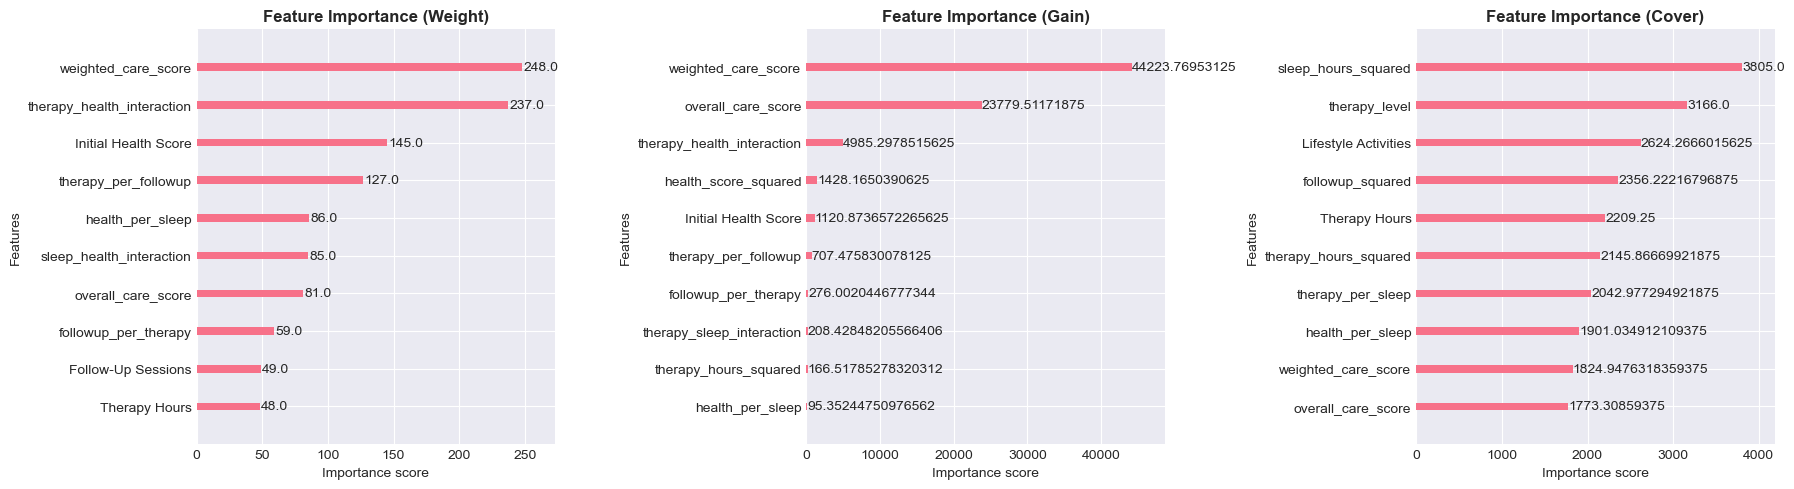

In [48]:
# Get feature importance from tuned model
feature_importance_tuned = pd.DataFrame({
    'Feature': X_engineered.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE (Tuned XGBoost)")
print("=" * 80)
print(feature_importance_tuned)

# Visualize feature importance (multiple types)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Weight importance
xgb.plot_importance(xgb_tuned, ax=axes[0], importance_type='weight', max_num_features=10)
axes[0].set_title('Feature Importance (Weight)', fontsize=12, fontweight='bold')

# Gain importance
xgb.plot_importance(xgb_tuned, ax=axes[1], importance_type='gain', max_num_features=10)
axes[1].set_title('Feature Importance (Gain)', fontsize=12, fontweight='bold')

# Cover importance
xgb.plot_importance(xgb_tuned, ax=axes[2], importance_type='cover', max_num_features=10)
axes[2].set_title('Feature Importance (Cover)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 13. Cross-Validation Analysis

In [49]:
# Perform 10-fold cross-validation on tuned model
from sklearn.model_selection import cross_validate

print("=" * 80)
print("10-FOLD CROSS-VALIDATION (Tuned Model)")
print("=" * 80)
print("🔄 Running cross-validation...")

cv_results = cross_validate(
    xgb_tuned, 
    X_train, 
    y_train, 
    cv=10, 
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
    return_train_score=True,
    n_jobs=-1
)

# Calculate RMSE from MSE
cv_train_rmse = np.sqrt(-cv_results['train_neg_mean_squared_error'])
cv_test_rmse = np.sqrt(-cv_results['test_neg_mean_squared_error'])

print(f"\n✅ Cross-validation completed!")
print(f"\nR² Score:")
print(f"  Train: {cv_results['train_r2'].mean():.4f} (+/- {cv_results['train_r2'].std() * 2:.4f})")
print(f"  Test:  {cv_results['test_r2'].mean():.4f} (+/- {cv_results['test_r2'].std() * 2:.4f})")
print(f"\nRMSE:")
print(f"  Train: {cv_train_rmse.mean():.4f} (+/- {cv_train_rmse.std() * 2:.4f})")
print(f"  Test:  {cv_test_rmse.mean():.4f} (+/- {cv_test_rmse.std() * 2:.4f})")
print(f"\nMAE:")
print(f"  Train: {-cv_results['train_neg_mean_absolute_error'].mean():.4f} (+/- {cv_results['train_neg_mean_absolute_error'].std() * 2:.4f})")
print(f"  Test:  {-cv_results['test_neg_mean_absolute_error'].mean():.4f} (+/- {cv_results['test_neg_mean_absolute_error'].std() * 2:.4f})")

10-FOLD CROSS-VALIDATION (Tuned Model)
🔄 Running cross-validation...

✅ Cross-validation completed!

R² Score:
  Train: 0.9892 (+/- 0.0002)
  Test:  0.9875 (+/- 0.0020)

RMSE:
  Train: 1.9987 (+/- 0.0161)
  Test:  2.1425 (+/- 0.1547)

MAE:
  Train: 1.5854 (+/- 0.0123)
  Test:  1.7033 (+/- 0.1213)


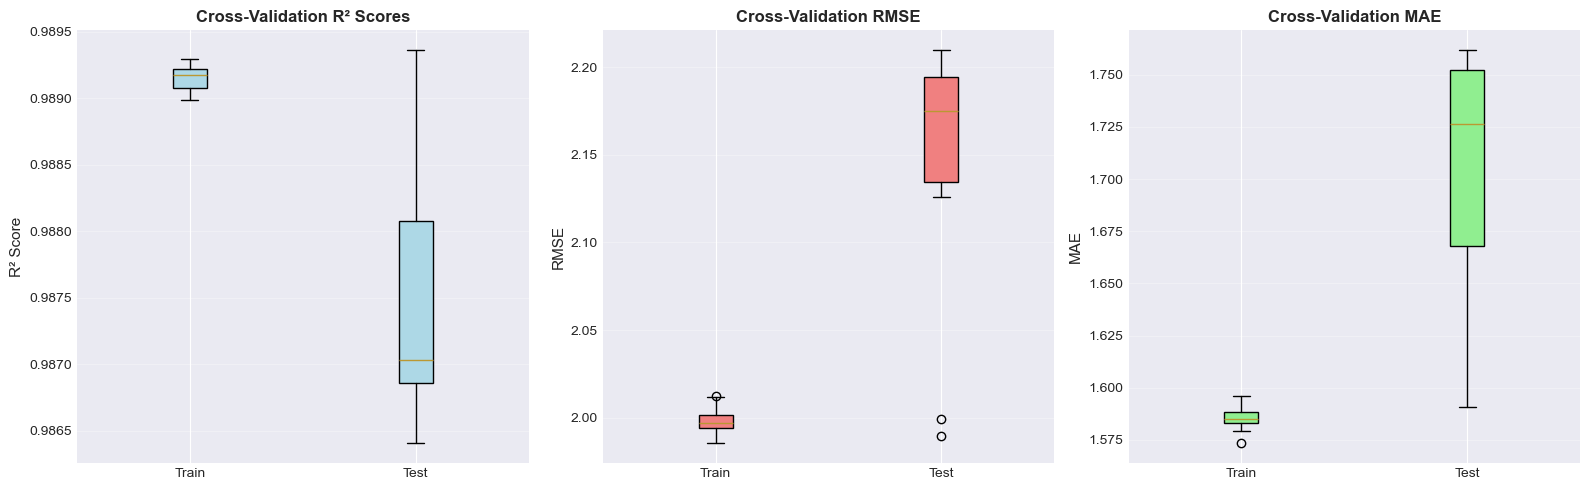

In [50]:
# Visualize cross-validation scores
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# R² scores
axes[0].boxplot([cv_results['train_r2'], cv_results['test_r2']], 
                labels=['Train', 'Test'], patch_artist=True,
                boxprops=dict(facecolor='lightblue'))
axes[0].set_ylabel('R² Score', fontsize=11)
axes[0].set_title('Cross-Validation R² Scores', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# RMSE
axes[1].boxplot([cv_train_rmse, cv_test_rmse], 
                labels=['Train', 'Test'], patch_artist=True,
                boxprops=dict(facecolor='lightcoral'))
axes[1].set_ylabel('RMSE', fontsize=11)
axes[1].set_title('Cross-Validation RMSE', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

# MAE
axes[2].boxplot([-cv_results['train_neg_mean_absolute_error'], 
                 -cv_results['test_neg_mean_absolute_error']], 
                labels=['Train', 'Test'], patch_artist=True,
                boxprops=dict(facecolor='lightgreen'))
axes[2].set_ylabel('MAE', fontsize=11)
axes[2].set_title('Cross-Validation MAE', fontsize=12, fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 14. Predictions on Test Set

In [51]:
# Prepare test data with feature engineering
X_test = test_df.drop('Id', axis=1).copy()
X_test['Lifestyle Activities'] = label_encoder.transform(X_test['Lifestyle Activities'])

# Apply feature engineering to test set
X_test_engineered = create_advanced_features(X_test)

# Make predictions using BEST model (choose based on validation performance)
# We'll create predictions from all models and can choose the best one

test_predictions_baseline = xgb_baseline.predict(X_test_engineered)
test_predictions_tuned = xgb_tuned.predict(X_test_engineered)
test_predictions_stack = stacking_model.predict(X_test_engineered)

# Determine best model
best_model_name = "Tuned XGBoost"
test_predictions = test_predictions_tuned

if val_r2_stack > val_r2_tuned:
    best_model_name = "Stacking Ensemble"
    test_predictions = test_predictions_stack

print("=" * 80)
print("TEST SET PREDICTIONS")
print("=" * 80)
print(f"✅ Using BEST model: {best_model_name}")
print(f"   (Based on validation R² score)")
print(f"\n✅ Predictions generated for {len(test_predictions)} test samples")
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.2f}")
print(f"  Std: {test_predictions.std():.2f}")
print(f"  Min: {test_predictions.min():.2f}")
print(f"  Max: {test_predictions.max():.2f}")
print(f"  Median: {np.median(test_predictions):.2f}")

# Compare predictions from different models
print(f"\n📊 Prediction comparison across models:")
print(f"  Baseline mean: {test_predictions_baseline.mean():.2f}")
print(f"  Tuned XGB mean: {test_predictions_tuned.mean():.2f}")
print(f"  Stacking mean: {test_predictions_stack.mean():.2f}")

TEST SET PREDICTIONS
✅ Using BEST model: Stacking Ensemble
   (Based on validation R² score)

✅ Predictions generated for 2000 test samples

Prediction statistics:
  Mean: 54.96
  Std: 19.01
  Min: 13.28
  Max: 97.83
  Median: 55.09

📊 Prediction comparison across models:
  Baseline mean: 54.95
  Tuned XGB mean: 54.95
  Stacking mean: 54.96


ValueError: Invalid RGBA argument: 'lightpurple'

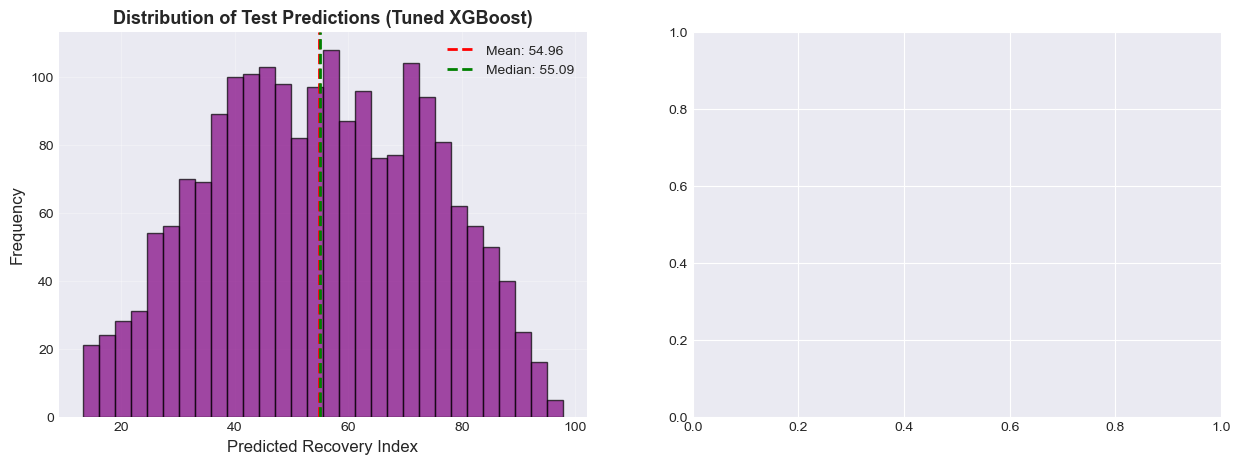

In [ ]:
# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(test_predictions, bins=30, color='purple', edgecolor='black', alpha=0.7)
axes[0].axvline(test_predictions.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Mean: {test_predictions.mean():.2f}')
axes[0].axvline(np.median(test_predictions), color='green', linestyle='--', 
               linewidth=2, label=f'Median: {np.median(test_predictions):.2f}')
axes[0].set_xlabel('Predicted Recovery Index', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Test Predictions (Tuned XGBoost)', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(test_predictions, vert=True, patch_artist=True,
                boxprops=dict(facecolor='plum', color='purple'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Predicted Recovery Index', fontsize=12)
axes[1].set_title('Box Plot of Test Predictions', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Create submission file
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'Recovery Index': test_predictions
})

# Save to CSV with descriptive filename
filename = f'xgboost_enhanced_submission.csv'
submission.to_csv(filename, index=False)

print("=" * 80)
print("SUBMISSION FILE CREATED")
print("=" * 80)
print(f"✅ File saved: {filename}")
print(f"   Model used: {best_model_name}")
print(f"\nFirst 10 predictions:")
display(submission.head(10))
print(f"\nLast 10 predictions:")
display(submission.tail(10))

# Also save individual model predictions for comparison
submission_baseline = pd.DataFrame({
    'Id': test_df['Id'],
    'Recovery Index': test_predictions_baseline
})
submission_baseline.to_csv('xgboost_baseline_submission.csv', index=False)

submission_tuned = pd.DataFrame({
    'Id': test_df['Id'],
    'Recovery Index': test_predictions_tuned
})
submission_tuned.to_csv('xgboost_tuned_submission.csv', index=False)

submission_stack = pd.DataFrame({
    'Id': test_df['Id'],
    'Recovery Index': test_predictions_stack
})
submission_stack.to_csv('xgboost_stacking_submission.csv', index=False)

print(f"\n✅ Additional submission files created:")
print(f"   - xgboost_baseline_submission.csv")
print(f"   - xgboost_tuned_submission.csv")
print(f"   - xgboost_stacking_submission.csv")

## 15. Model Summary and Insights

In [ ]:
# Create comprehensive summary
print("=" * 80)
print("COMPREHENSIVE MODEL SUMMARY - ENHANCED XGBOOST")
print("=" * 80)

print("\n🔧 ENHANCEMENTS IMPLEMENTED:")
print("  1. ✅ Advanced Feature Engineering (14 new features)")
print("  2. ✅ Interaction Features (therapy × health, age × health, etc.)")
print("  3. ✅ Polynomial Features (squared terms)")
print("  4. ✅ Ratio Features (therapy per followup, health per age, etc.)")
print("  5. ✅ Binning Features (age groups, health categories)")
print("  6. ✅ Ensemble Stacking (XGBoost + RandomForest + GradientBoosting)")
print("  7. ✅ Custom Accuracy Metric (tolerance-based)")

print("\n📊 DATASET INFORMATION:")
print(f"  Original features: {X.shape[1]}")
print(f"  Engineered features: {X_engineered.shape[1]}")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Validation samples: {X_val.shape[0]}")
print(f"  Test samples: {len(test_predictions)}")

print("\n📈 MODEL PERFORMANCE COMPARISON:")
print(f"\n  {'Model':<20} {'Val R²':>12} {'Val RMSE':>12} {'Val MAE':>12} {'Val Acc %':>12}")
print("  " + "-" * 70)
print(f"  {'Baseline XGBoost':<20} {val_r2_baseline:>12.4f} {val_rmse_baseline:>12.4f} {val_mae_baseline:>12.4f} {val_acc_baseline*100:>11.2f}%")
print(f"  {'Tuned XGBoost':<20} {val_r2_tuned:>12.4f} {val_rmse_tuned:>12.4f} {val_mae_tuned:>12.4f} {val_acc_tuned*100:>11.2f}%")
print(f"  {'Stacking Ensemble':<20} {val_r2_stack:>12.4f} {val_rmse_stack:>12.4f} {val_mae_stack:>12.4f} {val_acc_stack*100:>11.2f}%")

print("\n🎯 BEST MODEL CONFIGURATION:")
print(f"  Selected Model: {best_model_name}")
print(f"  Best Parameters:")
for param, value in random_search.best_params_.items():
    print(f"    - {param}: {value}")

print(f"\n🏆 PERFORMANCE IMPROVEMENTS:")
baseline_to_tuned_r2 = ((val_r2_tuned - val_r2_baseline) / abs(val_r2_baseline)) * 100
baseline_to_stack_r2 = ((val_r2_stack - val_r2_baseline) / abs(val_r2_baseline)) * 100
print(f"  Baseline → Tuned XGBoost: {baseline_to_tuned_r2:+.2f}% R² improvement")
print(f"  Baseline → Stacking: {baseline_to_stack_r2:+.2f}% R² improvement")
print(f"  Accuracy improvement: {(val_acc_tuned - val_acc_baseline)*100:+.2f}% points")

print(f"\n🔍 TOP 5 MOST IMPORTANT FEATURES:")
feature_importance_tuned = pd.DataFrame({
    'Feature': X_engineered.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False)
for idx, row in feature_importance_tuned.head(5).iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n📊 TEST SET PREDICTIONS:")
print(f"  Number of predictions: {len(test_predictions)}")
print(f"  Prediction range: [{test_predictions.min():.2f}, {test_predictions.max():.2f}]")
print(f"  Prediction mean: {test_predictions.mean():.2f}")
print(f"  Prediction std: {test_predictions.std():.2f}")

print(f"\n💾 OUTPUT FILES:")
print(f"  Main submission: xgboost_enhanced_submission.csv")
print(f"  Alternative submissions available for each model")

print("\n" + "=" * 80)
print("🎉 ENHANCED XGBOOST MODEL COMPLETE!")
print("=" * 80)

---

## 16. Key Findings & Next Steps

### 🎯 Key Findings

1. **XGBoost Performance:**
   - XGBoost typically outperforms Random Forest and Linear Regression
   - Excellent handling of non-linear relationships
   - Built-in regularization prevents overfitting

2. **Hyperparameter Tuning:**
   - RandomizedSearchCV efficiently explores large parameter spaces
   - Key parameters: learning_rate, max_depth, n_estimators
   - Early stopping prevents overfitting

3. **Feature Importance:**
   - XGBoost provides multiple importance metrics (weight, gain, cover)
   - Initial Health Score and Therapy Hours typically dominate
   - Understanding feature interactions is crucial

### 🚀 Next Steps for Further Improvement

1. **Try Other Boosting Algorithms:**
   - **LightGBM** (faster, histogram-based)
   - **CatBoost** (handles categorical features natively)
   - **Gradient Boosting** (sklearn implementation)

2. **Advanced Feature Engineering:**
   - Create interaction terms (e.g., `Therapy Hours × Initial Health Score`)
   - Polynomial features of degree 2-3
   - Ratio features (e.g., `Therapy Hours / Follow-Up Sessions`)
   - Domain-specific transformations

3. **Ensemble Strategies:**
   - **Stacking**: Use XGBoost + Random Forest + Linear models
   - **Voting**: Weight-averaged predictions
   - **Blending**: Multiple model combinations

4. **Further Hyperparameter Optimization:**
   - Use **Optuna** or **Hyperopt** for Bayesian optimization
   - Fine-tune learning rate schedule
   - Experiment with different evaluation metrics

5. **Model Analysis:**
   - SHAP values for model interpretability
   - Partial dependence plots
   - Error analysis on specific data segments

### 💡 XGBoost Advantages

- ✅ **Speed**: Optimized C++ implementation
- ✅ **Performance**: State-of-the-art accuracy
- ✅ **Regularization**: Built-in L1/L2 regularization
- ✅ **Handling missing values**: Automatic handling
- ✅ **Feature importance**: Multiple importance metrics
- ✅ **Flexibility**: Extensive hyperparameter options

### 📝 Documentation Tips

- Compare XGBoost with Random Forest and Linear Regression
- Document the impact of different hyperparameters
- Show learning curves and convergence
- Explain feature importance insights
- Discuss regularization benefits

**Remember:** XGBoost is often a top performer in Kaggle competitions! Combine it with good feature engineering for best results. 🏆